In [5]:
import os
import math
from collections import defaultdict
from typing import List, Optional 

import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

color_pallette = 'muted'
sns.set_theme(style='whitegrid', font_scale=2, palette=color_pallette, 
              rc={'font.family': 'serif', 'font.serif': 'Times New Roman', 'mathtext.fontset': 'dejavuserif'})

In [6]:
PROJECT_FOLDER = os.path.dirname(os.path.abspath(''))
DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data')

KB = float(1024)
MB = float(KB ** 2)
SECUNDS_IN_MINUTE = 60

titlesize = 20

cols_to_display = ['task_name', 'model_name', 'accuracy', 'macro avg_f1-score', 'macro avg_recall', 
                   'macro avg_precision', 'training_time', 'eval_time',
                   'model_size [MB]', 'memory [MB]', 'parameters']

def manage_model_name(name: str) -> str:
    spl = name.split('/')
    if len(spl) == 2:
        return spl[1]
    else:
        return name

def load_results_df(file_path: str):
    df = pd.read_csv(file_path)
    df['model_name'] = df['model_name'].apply(lambda x: manage_model_name(x))
    df['model_size [MB]'] = df['model_size']/MB
    df['memory [MB]'] = df['memory']/MB
    df['training_time_in_minutes'] = df['training_time']/SECUNDS_IN_MINUTE
    return df

In [7]:
def get_df_for_different_models(task_level, basic = True, theseus = True, tinybert = True):
    subdir = os.path.join(DATA_FOLDER, f'domain_results_{task_level}')
    df_list = list()

    # BERT_Base, DistilBERT, GeneralTinyBERT, xtremedistil
    if basic:
        file_name = f'domain-results-{task_level}.csv'
        file_path = os.path.join(subdir, file_name)
        df_base = load_results_df(file_path)
        df_list.append(df_base)

    # BERT-of-Theseus
    if theseus:
        file_name = f'domain-results-bert-of-theseus-{task_level}.csv'
        file_path = os.path.join(subdir, file_name)
        df_theseus = load_results_df(file_path)
        df_theseus = df_theseus.rename(columns={'per_gpu_train_batch_size': 'batch_size', 'num_train_epochs': 'epochs'})

        columns_to_drop = set(df_theseus.columns) - set(df_base.columns)
        df_theseus = df_theseus.drop(columns=columns_to_drop)
        df_list.append(df_theseus)

    # KD TinyBERT
    if tinybert:
        file_name = f'domain-results-kd-tinybert-{task_level}.csv'
        file_path = os.path.join(subdir, file_name)
        df_tinybert = load_results_df(file_path)
        df_tinybert = df_tinybert.rename(columns={'train_batch_size': 'batch_size', 
                                              'num_train_epochs': 'epochs',
                                              'warmup_proportion':'warmup_steps'})

        columns_to_drop = set(df_tinybert.columns) - set(df_base.columns)
        df_tinybert = df_tinybert.drop(columns=columns_to_drop)
        df_list.append(df_tinybert)

    df = pd.concat(df_list, ignore_index=True)
    return df

In [44]:
def get_type(row, task_level) -> str:
    training_task = row['task_name']
    eval_task = row['eval_task_name']
    if 'all' in training_task:
        eval_type = 'MD'
    elif training_task == eval_task:
        eval_type = 'SD'
    else:
        eval_type = 'DO'

    if task_level == 'sentence':
        eval_type += 'S'
    elif task_level == 'text':
        eval_type += 'T'
    else:
        raise ValueError

    eval_type += '-'
    if 'hotels' in eval_task:
        eval_type += 'H'
    elif 'medicine' in eval_task:
        eval_type += 'M'
    elif 'products' in eval_task:
        eval_type += 'P'
    elif 'reviews' in eval_task:
        eval_type += 'S'
    else:
        raise ValueError

    return eval_type 

def get_domain(row) -> str:
    domain_type = ''
    eval_task = row['eval_task_name']
    if 'hotels' in eval_task:
        domain_type += 'Hotele'
    elif 'medicine' in eval_task:
        domain_type += 'Medycyna'
    elif 'products' in eval_task:
        domain_type += 'Produkty'
    elif 'reviews' in eval_task:
        domain_type += 'Szkoła'
    else:
        raise ValueError

    return domain_type 

def get_df_with_results(df: pd.DataFrame, models: List[str], task_level: str):
    df = df[df['model_name'].isin(models)].copy()    
    cols = ['model_name', 'task_name', 'eval_task_name']
    
    measure_cols = ['accuracy', 'macro avg_f1-score']
    if task_level == 'sentence':
        measure_cols += ['z_plus_m_f1-score', 'z_amb_f1-score', 'z_zero_f1-score', 'z_minus_m_f1-score']
    elif task_level == 'text':
        measure_cols += ['meta_plus_m_f1-score', 'meta_amb_f1-score', 'meta_zero_f1-score', 'meta_minus_m_f1-score']
        
    cols += measure_cols    
    
    df = df[df['model_name'].isin(models)].copy()[cols] 
    df = df.groupby(['model_name', 'task_name', 'eval_task_name'], as_index=False, sort=False).mean()
        
    def rename(name: str) -> str:
        names = {
            'bert-base-uncased': 'BERT$_{\mathrm{B}}$', 
            'distilbert-base-uncased': 'DistilB',
            'xtremedistil-l6-h256-uncased': 'XD',
            'TinyBERT_General_6L_768D': 'TB$_{6,\mathrm{FT}}$',
            'TinyBERT_6L_768D': 'TB$_{6,\mathrm{KD}}$',
            'TinyBERT_General_4L_312D': 'TB$_{4,\mathrm{FT}}$',
            'TinyBERT_4L_312D': 'TB$_{4,\mathrm{KD}}$',
            'Bert-of-Theseus': 'BoT',
        }
        return names[name] 
    
    def add_model_id(name: str) -> str:
        ids = {
            'bert-base-uncased': 1, 
            'distilbert-base-uncased': 2,
            'TinyBERT_General_6L_768D': 3,
            'TinyBERT_6L_768D': 4,
            'Bert-of-Theseus': 5,
            'xtremedistil-l6-h256-uncased': 6,
            'TinyBERT_General_4L_312D': 7,
            'TinyBERT_4L_312D': 8
        }
        return ids[name] 
   

    df['model_id'] = df['model_name'].apply(lambda x: add_model_id(x)) 
    df['model_name'] = df['model_name'].apply(lambda x: rename(x))   
    df['type'] =df.apply(lambda row: get_type(row, task_level), axis=1)
        
    def format_score(x):
        if x == 0:
            return '00.00'
        else:
            return f'{round(100*x, 2):.2f}'
        
    for col in measure_cols:
        df[col] = df[col].apply(lambda x: format_score(x))
     
#     df = df.sort_values(['task_name', 'eval_task_name'])
    df = df.sort_values(['type', 'model_id'])

    df = df[['type', 'model_name'] + measure_cols]

    df = df.rename(columns={
        'type': 'Type', 'model_name': 'Method', 'accuracy': 'Acc.', 'macro avg_f1-score': 'Macro F1'
    })
    
    if task_level == 'sentence':
        df = df.rename(columns={
            'z_plus_m_f1-score': 'SP', 'z_amb_f1-score': 'AMB',
            'z_zero_f1-score': '0', 'z_minus_m_f1-score': 'SN'
        })
    elif task_level == 'text':
        df = df.rename(columns={
            'meta_plus_m_f1-score': 'SP', 'meta_amb_f1-score': 'AMB',
            'meta_zero_f1-score': '0', 'meta_minus_m_f1-score': 'SN'
        })   

    return df

In [90]:
def visualize_results(df: pd.DataFrame, models: List[str], legend_labels: Optional[List[str]] = None,
                              suptitle: str = '', figsize=(12, 5), file_name=None):

    cols = len(domains)
    fig, axis = plt.subplots(1, cols, figsize=figsize, constrained_layout=True)

    for domain, ax in zip(domains, axis):
        domain_df = df[df['Domain'] == domain]
        sns.barplot(x='Domain', y='macro avg_f1-score', hue='model_name', hue_order=models, edgecolor="0",
                    ci='sd', errwidth=1.25, capsize=0.07, data=domain_df, ax=ax)

        ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
        ax.set_ylim(bottom=round(domain_df['macro avg_f1-score'].quantile(0.01)-0.01, 2),
                    top=round(domain_df['macro avg_f1-score'].quantile(0.99)+0.01, 2))
        ax.set_xlabel('')
        ax.set_xticklabels('')
        ax.set_title(domain, fontsize=24)
        ax.set_ylabel('Macro F1')
        ax.get_legend().remove()

    handles, labels = ax1.get_legend_handles_labels()

    if legend_labels is not None:
        labels = legend_labels

    fig.legend(handles, labels, title='Metoda',  fontsize=18, title_fontsize=22,
               bbox_to_anchor=(1.02, 0.9), loc=2, borderaxespad=0., fancybox=True)

    fig.suptitle(suptitle)    
    
    if file_name is None:
        file_name = suptitle.replace(':', '').replace(' ','-') + '_pl'
        
    fig.savefig(file_name + '.svg', bbox_inches='tight')   

# Texts level

In [95]:
task_level = 'text'
df = get_df_for_different_models(task_level=task_level)

df['Type'] = df.apply(lambda row: get_type(row, task_level), axis=1)
df['Domain'] = df.apply(lambda row: get_domain(row), axis=1)

df_sd  = df.loc[df["Type"].str.startswith('SD', na=False)]
df_do  = df.loc[df["Type"].str.startswith('DO', na=False)]

In [96]:
domains = df['Domain'].unique()

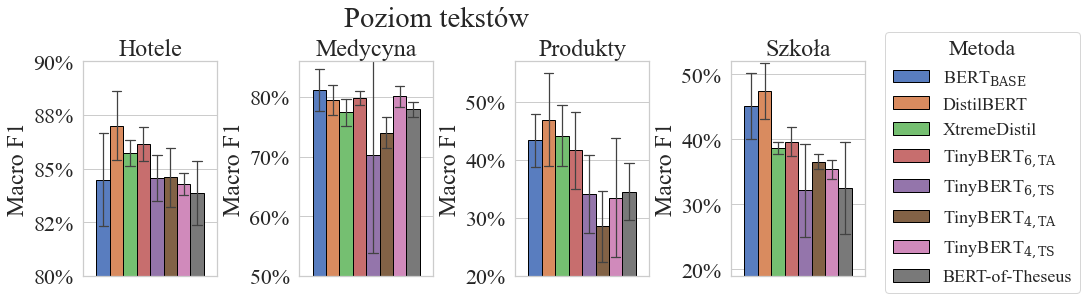

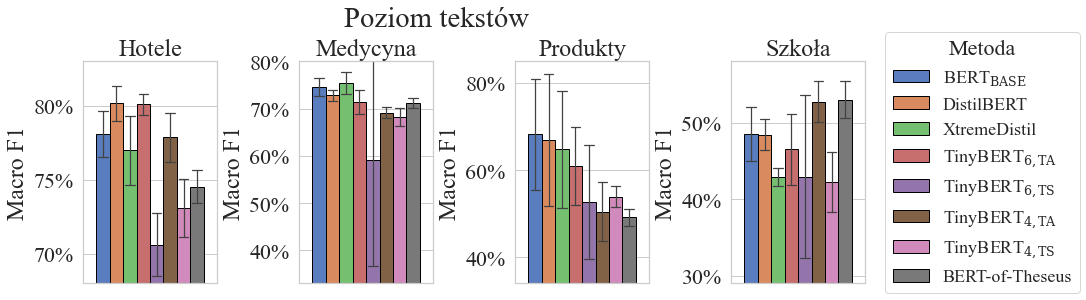

In [97]:
models = ['bert-base-uncased', 'distilbert-base-uncased',
          'xtremedistil-l6-h256-uncased',
          'TinyBERT_General_6L_768D', 'TinyBERT_6L_768D',
          'TinyBERT_General_4L_312D', 'TinyBERT_4L_312D', 
          'Bert-of-Theseus']

legend_labels = [r'BERT$_\mathrm{BASE}}$', 'DistilBERT', 'XtremeDistil',
                 r'TinyBERT$_{6, \mathrm{TA}}$', r'TinyBERT$_{6, \mathrm{TS}}$',
                 r'TinyBERT$_{4, \mathrm{TA}}$', 'TinyBERT$_{4, \mathrm{TS}}$', 
                 'BERT-of-Theseus']

visualize_results(df_sd, models, legend_labels, suptitle='Poziom tekstów', figsize=(12, 4),
                         file_name='texts_sd')

visualize_results(df_do, models, legend_labels, suptitle='Poziom tekstów', figsize=(12, 4),
                         file_name='texts_do')

In [6]:
# df['model_name'].unique()

In [7]:
# df.columns

In [8]:
models = ['bert-base-uncased', 'distilbert-base-uncased',
          'xtremedistil-l6-h256-uncased',
          'TinyBERT_General_6L_768D', 'TinyBERT_6L_768D',
          'TinyBERT_General_4L_312D', 'TinyBERT_4L_312D', 
          'Bert-of-Theseus']

result_df = get_df_with_results(df, models, task_level)
# display(result_df)
# with pd.option_context('display.max_rows', None):
#     display(result_df)

df_do  = result_df.loc[result_df["Type"].str.startswith('DO', na=False)]
df_sd  = result_df.loc[result_df["Type"].str.startswith('SD', na=False)]

df_do.to_csv(f'domain_DO_results_{task_level}.csv', index=False)
df_sd.to_csv(f'domain_SD_results_{task_level}.csv', index=False)

In [9]:
# cols = ['name', 'model_name', 'task_name', 'eval_task_name', 'accuracy']
# df2 = df[df['model_name'] == 'bert-base-uncased'][cols]
# df2 = df2.loc[df2.groupby(['task_name', 'eval_task_name'])["accuracy"].idxmax()] 

# lines = list()
# for n in df2['name']:
#     lines.append(f'cp -r DistilledVsNondistilled/models_v2/bert-base-uncased/{n}/.' + 
#                  f" Pretrained-Language-Model/TinyBERT/data/models/bert-base-uncased/{n.split('-run-')[0]}\n")

# with open('copy_bert_to_tiny_text.sh', 'w') as f:
#     f.writelines(lines)
#
# lines = list()
# for n in df2['name']:
#     lines.append(f'cp -r DistilledVsNondistilled/models_v2/bert-base-uncased/{n}/.' + 
#                  f" BERT-of-Theseus/data/models/bert-base-uncased/{n.split('-run-')[0]}\n")

# with open('copy_bert_to_theseus_text.sh', 'w') as f:
#     f.writelines(lines)

# Sentences level

In [98]:
task_level = 'sentence'
df = get_df_for_different_models(task_level=task_level)

df['Type'] = df.apply(lambda row: get_type(row, task_level), axis=1)
df['Domain'] = df.apply(lambda row: get_domain(row), axis=1)

df_sd  = df.loc[df["Type"].str.startswith('SD', na=False)]
df_do  = df.loc[df["Type"].str.startswith('DO', na=False)]

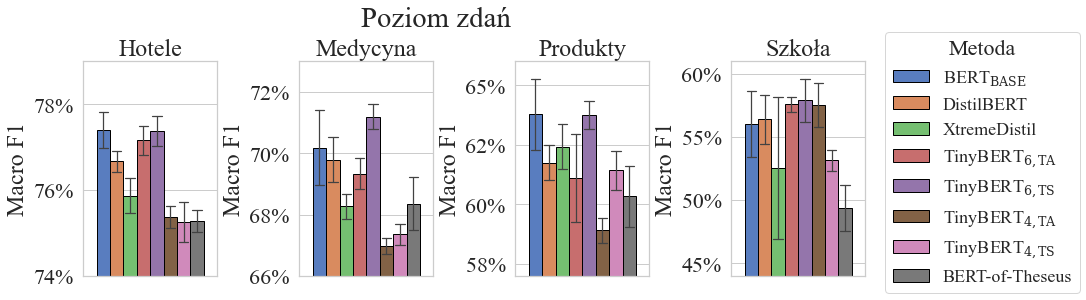

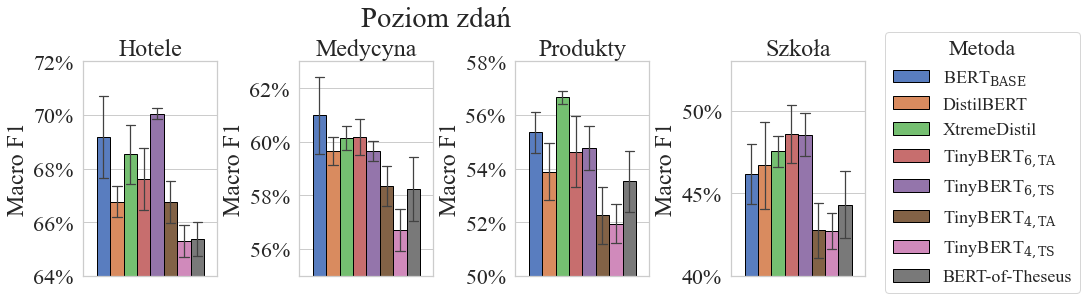

In [99]:
models = ['bert-base-uncased', 'distilbert-base-uncased',
          'xtremedistil-l6-h256-uncased',
          'TinyBERT_General_6L_768D', 'TinyBERT_6L_768D',
          'TinyBERT_General_4L_312D', 'TinyBERT_4L_312D', 
          'Bert-of-Theseus']

legend_labels = [r'BERT$_\mathrm{BASE}}$', 'DistilBERT', 'XtremeDistil',
                 r'TinyBERT$_{6, \mathrm{TA}}$', r'TinyBERT$_{6, \mathrm{TS}}$',
                 r'TinyBERT$_{4, \mathrm{TA}}$', 'TinyBERT$_{4, \mathrm{TS}}$', 
                 'BERT-of-Theseus']

visualize_results(df_sd, models, legend_labels, suptitle='Poziom zdań', figsize=(12, 4),
                         file_name=f'{task_level}_sd')

visualize_results(df_do, models, legend_labels, suptitle='Poziom zdań', figsize=(12, 4),
                         file_name=f'{task_level}_do')

In [83]:
df

,name,eval_task_name,model_name,task_name,epochs,batch_size,learning_rate,weight_decay,warmup_steps,max_seq_length,...,weighted avg_f1-score,weighted avg_support,model_size,memory,parameters,model_size [MB],memory [MB],training_time_in_minutes,Type,Domain
0,multiemo_en_Nhotels_sentence-run-1,multiemo_en_hotels_sentence,bert-base-uncased,multiemo_en_Nhotels_sentence,4.0,16,0.00005,0.01,0.0,128,...,0.739940,2485,438025389,437945360,109485316,417.733563,417.657242,14.119821,DOS-H,Hotele
1,multiemo_en_Nhotels_sentence-run-2,multiemo_en_hotels_sentence,bert-base-uncased,multiemo_en_Nhotels_sentence,4.0,16,0.00005,0.01,0.0,128,...,0.724478,2485,438025389,437945360,109485316,417.733563,417.657242,14.113863,DOS-H,Hotele
2,multiemo_en_Nhotels_sentence-run-3,multiemo_en_hotels_sentence,bert-base-uncased,multiemo_en_Nhotels_sentence,4.0,16,0.00005,0.01,0.0,128,...,0.739783,2485,438025389,437945360,109485316,417.733563,417.657242,14.097790,DOS-H,Hotele
3,multiemo_en_Nhotels_sentence-run-4,multiemo_en_hotels_sentence,bert-base-uncased,multiemo_en_Nhotels_sentence,4.0,16,0.00005,0.01,0.0,128,...,0.760714,2485,438025389,437945360,109485316,417.733563,417.657242,14.133753,DOS-H,Hotele
4,multiemo_en_Nhotels_sentence-run-5,multiemo_en_hotels_sentence,bert-base-uncased,multiemo_en_Nhotels_sentence,4.0,16,0.00005,0.01,0.0,128,...,0.750884,2485,438025389,437945360,109485316,417.733563,417.657242,14.066190,DOS-H,Hotele
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,multiemo_en_reviews_sentence-run-1,multiemo_en_reviews_sentence,TinyBERT_6L_768D,multiemo_en_reviews_sentence,4.0,16,0.00005,0.01,0.0,128,...,0.632608,253,270236395,270194704,67548676,257.717509,257.677750,3.326384,SDS-S,Szkoła
316,multiemo_en_reviews_sentence-run-2,multiemo_en_reviews_sentence,TinyBERT_6L_768D,multiemo_en_reviews_sentence,4.0,16,0.00005,0.01,0.0,128,...,0.653506,253,270236395,270194704,67548676,257.717509,257.677750,3.360159,SDS-S,Szkoła
317,multiemo_en_reviews_sentence-run-3,multiemo_en_reviews_sentence,TinyBERT_6L_768D,multiemo_en_reviews_sentence,4.0,16,0.00005,0.01,0.0,128,...,0.643954,253,270236395,270194704,67548676,257.717509,257.677750,3.337666,SDS-S,Szkoła
318,multiemo_en_reviews_sentence-run-4,multiemo_en_reviews_sentence,TinyBERT_6L_768D,multiemo_en_reviews_sentence,4.0,16,0.00005,0.01,0.0,128,...,0.637983,253,270236395,270194704,67548676,257.717509,257.677750,3.330049,SDS-S,Szkoła


In [11]:
# df.head(2)

In [12]:
models = ['bert-base-uncased', 'distilbert-base-uncased',
          'xtremedistil-l6-h256-uncased',
          'TinyBERT_General_6L_768D', 'TinyBERT_6L_768D',
          'TinyBERT_General_4L_312D', 'TinyBERT_4L_312D', 
          'Bert-of-Theseus']

result_df = get_df_with_results(df, models, task_level)
# display(result_df)
# with pd.option_context('display.max_rows', None):
#     display(result_df)

df_do  = result_df.loc[result_df["Type"].str.startswith('DO', na=False)]
df_sd  = result_df.loc[result_df["Type"].str.startswith('SD', na=False)]

df_do.to_csv(f'domain_DO_results_{task_level}.csv', index=False)
df_sd.to_csv(f'domain_SD_results_{task_level}.csv', index=False)

In [13]:
df_do

,Type,Method,Acc.,Macro F1,SP,AMB,0,SN
0,DOS-H,BERT$_{\mathrm{B}}$,74.28,69.18,79.95,50.94,64.99,80.84
8,DOS-H,DistilB,71.97,66.76,77.87,47.77,63.10,78.32
24,DOS-H,"TB$_{6,\mathrm{FT}}$",72.59,67.61,78.78,49.09,63.80,78.75
56,DOS-H,"TB$_{6,\mathrm{KD}}$",75.58,70.05,79.22,53.07,65.95,81.97
40,DOS-H,BoT,70.36,65.39,76.66,47.27,60.45,77.17
32,DOS-H,XD,74.05,68.53,78.21,49.74,65.40,80.75
16,DOS-H,"TB$_{4,\mathrm{FT}}$",71.70,66.74,76.02,49.15,63.37,78.41
48,DOS-H,"TB$_{4,\mathrm{KD}}$",71.76,65.29,75.26,45.28,61.42,79.20
1,DOS-M,BERT$_{\mathrm{B}}$,66.78,60.98,71.30,31.96,70.69,69.98
9,DOS-M,DistilB,65.88,59.65,70.20,31.08,67.97,69.34


In [14]:
# models = ['bert-base-uncased', 'distilbert-base-uncased',
#           'TinyBERT_General_4L_312D', 'TinyBERT_General_6L_768D',
#           'xtremedistil-l6-h256-uncased']

# result_df = get_df_with_results(df, models)
# display(result_df)
# result_df.to_csv('Multiemo EN All sentences.csv', index=False)

In [15]:
# cols = ['name', 'model_name', 'task_name', 'eval_task_name', 'accuracy', 'macro avg_f1-score',
#            'z_plus_m_f1-score', 'z_amb_f1-score', 'z_zero_f1-score', 'z_minus_m_f1-score']
# df2 = df[df['model_name'] == 'bert-base-uncased'][cols]
# df2 = df2.loc[df2.groupby(['task_name', 'eval_task_name'])["accuracy"].idxmax()] 

# lines = list()
# for n in df2['name']:
#     lines.append(f'cp -r DistilledVsNondistilled/models_v2/bert-base-uncased/{n}/.' + 
#                  f" BERT-of-Theseus/data/models/bert-base-uncased/{n.split('-run-')[0]}\n")

# with open('copy_bert_to_theseus_sentence.sh', 'w') as f:
#     f.writelines(lines)

# lines = list()
# for n in df2['name']:
#     lines.append(f'cp -r DistilledVsNondistilled/models_v2/bert-base-uncased/{n}/.' + 
#                  f" Pretrained-Language-Model/TinyBERT/data/models/bert-base-uncased/{n.split('-run-')[0]}\n")

# with open('copy_bert_to_tiny_sentence.sh', 'w') as f:
#     f.writelines(lines)